In [0]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import *
from imblearn.under_sampling import *


In [0]:
df_simple = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/df_sim_final.csv', na_values='n/a', index_col="Unnamed: 0")

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_simple 

TARGET       pc8  ...  HOUR_APPR_PROCESS_START  AMT_REQ_CREDIT_BUREAU_QRT
100002       1 -0.673036  ...                 0.434783                   0.000000
100003       0  0.160755  ...                 0.478261                   0.000000
100004       0 -0.198355  ...                 0.391304                   0.000000
100007       0 -0.179340  ...                 0.478261                   0.000000
100008       0 -0.827153  ...                 0.695652                   0.052632
...        ...       ...  ...                      ...                        ...
456246       0  0.346001  ...                 0.695652                   0.000000
456247       0 -0.427011  ...                 0.478261                   0.000000
456253       0  0.452683  ...                 0.391304                   0.000000
456254       1  0.220269  ...                 0.391304                   0.000000
456255       0  0.549394  ...                 0.869565                   0.000000

[216150 rows x 35 columns]

In [0]:
df_simple.columns

Index(['TARGET', 'pc8', 'pc5', 'pc11', 'pc10', 'pc1', 'EXT_SOURCE_3',
       'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_INCOME_TOTAL', 'pc6', 'pc4', 'pc3', 'REGION_POPULATION_RELATIVE',
       'ORGANIZATION_TYPE_Self-employed', 'ORGANIZATION_TYPE_Business',
       'OCCUPATION_TYPE_Middle', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_Finance',
       'OCCUPATION_TYPE_High', 'NAME_HOUSING_TYPE_Office apartment',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_EDUCATION_TYPE_Lower',
       'HOUR_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_QRT'],
      dtype='object')

In [0]:
X_df= df_simple.drop('TARGET', axis=1)
y_df= df_simple.TARGET

Metrics 함수정의

In [0]:
##혼동행렬
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, cf_report=False,
                          title='Confusion matrix', ax=None, cmap=plt.cm.Blues, cbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    if cf_report:
        print(classification_report(y_true,y_pred))
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    
    if cbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # "Magic" numbers (https://stackoverflow.com/a/26720422/10939610)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [0]:
##ROC CURVE
def plot_roc(y_true, y_pred, ax=None):
    """Plot ROC curve""" 
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
    roc_score = roc_auc_score(y_true,y_pred)
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)

    ax.set_title("Receiver Operating Characteristic")
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    ax.annotate('ROC: {:.5f}'.format(roc_score), [0.75,0.05])
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    fig.tight_layout()
    return roc_score

In [0]:
##혼동행렬 & ROC Curve
def plot_cmroc(y_true, y_pred, classes=[0,1], normalize=True, cf_report=False):
    """Convenience function to plot confusion matrix and ROC curve """
    fig,axes = plt.subplots(1,2, figsize=(9,4))
    plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=normalize, cf_report=cf_report, ax=axes[0])
    roc_score = plot_roc(y_true, y_pred, ax=axes[1])
    fig.tight_layout()
    plt.show()
    return roc_score

In [0]:
##Feature Importance
def feat_imps(clf, X_train, plot=False, n=None):
    """ Dataframe containing each feature with its corresponding importance in the given model
    
    Args
    ----
        model : model, classifier that supports .feature_importances_ (RandomForest, AdaBoost, ect..)
        X_train : array like, training data object
        plot : boolean, if True, plots the data in the form of a bargraph
        n : int, only applicable if plot=True, number of features to plot, (default=15)
        
    Returns
    -------
        pandas DataFrame : columns = feature name, importance
    """
    
    fi_df = pd.DataFrame({'feature':X_train.columns,
                          'importance':clf.feature_importances_}
                        ).sort_values(by='importance', ascending=False)
    if plot:
        fi_df[:(n if n is not None else 15)].plot.bar(x='feature',y='importance')
    else:
        return fi_df

CV + Classifier evaluator 

In [0]:
def evaluate_classifier(clf, df_scores, X_df, y_df, clf_name=None):
    acc_list = []
    bal_acc_list = []
    auc_list = []
    recall_list = []
    f1_list = []
    fbeta_list = []    
    
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
  
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 
    for train_index, test_index in kfold.split(X_df):
        X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
        y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
        X_train, X_test = X_train.values, X_test.values
        
        ###accuracy###
        acc = clf.fit(X_train, y_train).score(X_test, y_test)
        
        ###balanced accuracy###
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        ###AUC###
      
        if clf_name[0:2] in ('RF', 'XG', 'LG'):
              fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        else:
              fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test))
        aucs = auc(fpr, tpr) 

         ###Recall### 
        recall = recall_score(y_test, y_pred)

         ###F-1 Score###
        f1 = f1_score(y_test, y_pred)

        ###F-b Score###
        fbeta = fbeta_score(y_test, y_pred, 2)

        acc_list.append(acc)
        bal_acc_list.append(bal_acc)
        auc_list.append(aucs)
        recall_list.append(recall)
        f1_list.append(f1)
        fbeta_list.append(fbeta)   

    
    cv_acc = np.mean(acc_list)
    cv_bal_acc = np.mean(bal_acc_list)
    cv_auc = np.mean(auc_list)
    cv_recall = np.mean(recall_list)
    cv_f1 = np.mean(f1_list)
    cv_fb = np.mean(fbeta_list)
    
    clf_score = pd.DataFrame(
        {clf_name: [acc,bal_acc, aucs, recall, f1, fbeta]},
        index=['Accuracy', 'Balanced accuracy', 'AUC', 'Recall', 'F-1 score', 'F-beta Score']
    )  
    print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))
    print(fpr.round(decimals=2), tpr.round(decimals=2))
    #여기서는 상환능력있음이 0class를 가짐
    #위양성률(FPR) : 실제로는 1, 상환능력이 부족한 사람에게 상환할 수 있다고 판단한 비율
    df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores, X_train, y_test, y_pred, clf

In [0]:
df_scores = pd.DataFrame()

# 분류기 모델별/Sampling 방법별 적용

## 1.UnderSampling

In [0]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

### 1-1. Random Under Sampling

In [0]:
df_scores = pd.DataFrame()

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0, sampling_strategy=0.8),LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.76      0.84     39594
     class 1       0.18      0.56      0.27      3636

    accuracy                           0.74     43230
   macro avg       0.56      0.66      0.56     43230
weighted avg       0.88      0.74      0.80     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with RUS
Accuracy                 0.742
Balanced accuracy        0.661
AUC                      0.727
Recall                   0.564
F-1 score                0.269
F-beta Score             0.392

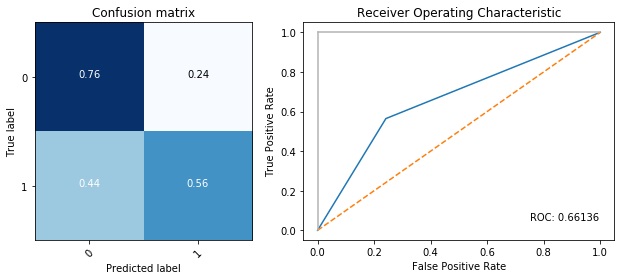

0.6613644581612276

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0, sampling_strategy=0.8),RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.76      0.85     39594
     class 1       0.18      0.57      0.28      3636

    accuracy                           0.75     43230
   macro avg       0.57      0.67      0.56     43230
weighted avg       0.89      0.75      0.80     43230

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.05
 0.06 0.07 0.07 0.08 0.09 0.1  0.11 0.12 0.14 0.15 0.16 0.18 0.19 0.21
 0.22 0.24 0.25 0.27 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47
 0.49 0.52 0.54 0.56 0.58 0.61 0.63 0.65 0.67 0.7  0.72 0.74 0.76 0.78
 0.8  0.82 0.84 0.86 0.88 0.9  0.91 0.93 0.94 0.96 0.97 0.97 0.98 0.99
 0.99 0.99 1.   1.   1.   1.   1.   1.   1.  ] [0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.02 0.02 0.03 0.04
 0.04 0.05 0.06 0.07 0.08 0.1  0.11 0.12 0.13 0.15 0.16 0.18 0.2  0.22
 0.24 0.26 0.28 0.31 0.32 0.34 0.37 0.39 0.41 0.43 0.45 0.48

LR with RUS  RF with RUS
Accuracy                 0.742        0.747
Balanced accuracy        0.661        0.668
AUC                      0.727        0.731
Recall                   0.564        0.574
F-1 score                0.269        0.276
F-beta Score             0.392        0.401

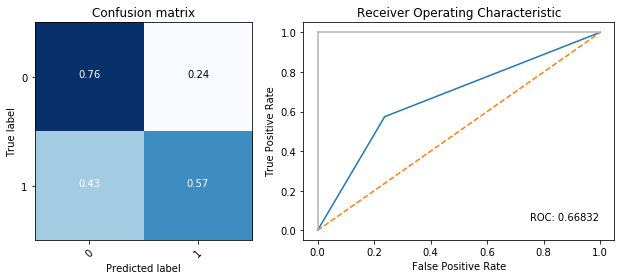

0.6683242293770216

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

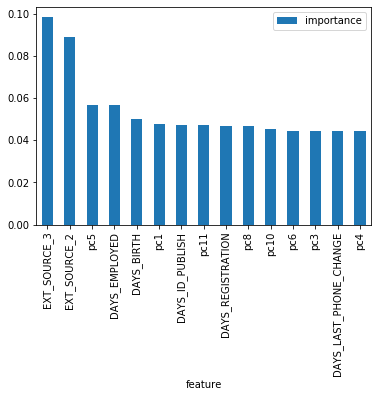

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
'''df_scores=pd.DataFrame()'''

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0, sampling_strategy=0.8),SGDClassifier(penalty= 'l2', max_iter=1000, loss='hinge'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with RUS")
df_scores


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.73      0.83     39594
     class 1       0.17      0.59      0.26      3636

    accuracy                           0.72     43230
   macro avg       0.56      0.66      0.54     43230
weighted avg       0.88      0.72      0.78     43230

[0.   0.   0.   ... 0.99 0.99 1.  ] [0. 0. 0. ... 1. 1. 1.]


LR with RUS  RF with RUS  SVM with RUS
Accuracy                 0.742        0.747         0.719
Balanced accuracy        0.661        0.668         0.659
AUC                      0.727        0.731         0.723
Recall                   0.564        0.574         0.587
F-1 score                0.269        0.276         0.260
F-beta Score             0.392        0.401         0.391

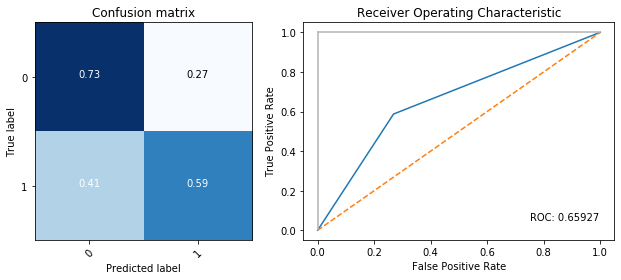

0.6592659512200651

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0, sampling_strategy=0.8),XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.76      0.85     39594
     class 1       0.19      0.60      0.28      3636

    accuracy                           0.75     43230
   macro avg       0.57      0.68      0.57     43230
weighted avg       0.89      0.75      0.80     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with RUS  RF with RUS  SVM with RUS  XGB with RUS
Accuracy                 0.742        0.747         0.719         0.746
Balanced accuracy        0.661        0.668         0.659         0.680
AUC                      0.727        0.731         0.723         0.745
Recall                   0.564        0.574         0.587         0.599
F-1 score                0.269        0.276         0.260         0.284
F-beta Score             0.392        0.401         0.391         0.415

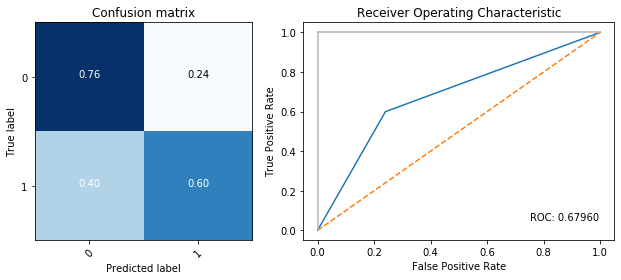

0.6795990233210318

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

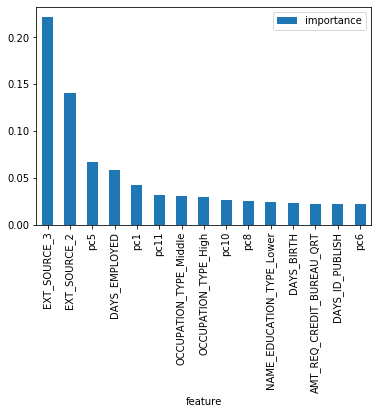

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 RandomUnderSampler(random_state=0, sampling_strategy=0.8),LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.73      0.82     39594
     class 1       0.16      0.58      0.26      3636

    accuracy                           0.71     43230
   macro avg       0.56      0.65      0.54     43230
weighted avg       0.88      0.71      0.78     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with RUS  RF with RUS  ...  XGB with RUS  LGBM with RUS
Accuracy                 0.742        0.747  ...         0.746          0.715
Balanced accuracy        0.661        0.668  ...         0.680          0.655
AUC                      0.727        0.731  ...         0.745          0.717
Recall                   0.564        0.574  ...         0.599          0.582
F-1 score                0.269        0.276  ...         0.284          0.256
F-beta Score             0.392        0.401  ...         0.415          0.385

[6 rows x 5 columns]

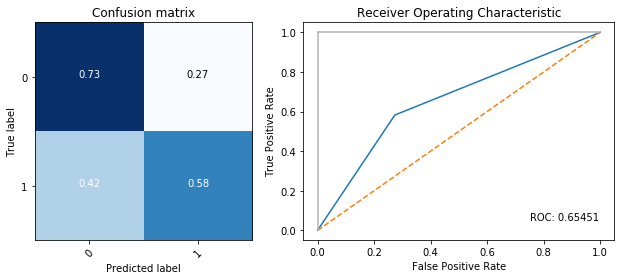

0.6545050038417995

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

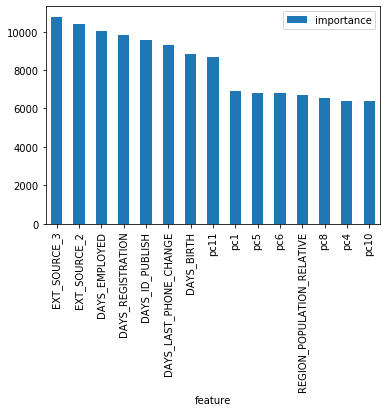

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-2. TomekLinks

In [0]:
#tl = TomekLinks(return_indices=True, ratio='majority',sampling_strategy=0.8)
tl = TomekLinks()


In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    tl , LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with Tomek")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    tl,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with Tomek")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    tl,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with Tomek")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
    tl,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with Tomek")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 tl,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with Tomek")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-3. OneSidedSelection(Tomek+CNN)

In [0]:
os = OneSidedSelection(random_state=0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    os ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with OSS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as 

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    os,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    os,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   os,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 os,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-4. Neighbourhood Cleaning Rule

In [0]:
ncr = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5, random_state=0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    ncr ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    ncr,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ncr,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   ncr,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 ncr,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-5. EditedNearestNeighbours

In [0]:
ENN = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    ENN ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    ENN,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ENN,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   ENN,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 ENN,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

## 2. Oversampling

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

### 2-1. Random Over Sampler

In [0]:
ROS = RandomOverSampler(random_state=0,sampling_strategy=0.8)

In [0]:
df_scores=pd.DataFrame()

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
   ROS ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with ROS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.76      0.84     39594
     class 1       0.18      0.57      0.27      3636

    accuracy                           0.74     43230
   macro avg       0.56      0.66      0.55     43230
weighted avg       0.88      0.74      0.79     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS
Accuracy                 0.740
Balanced accuracy        0.661
AUC                      0.727
Recall                   0.565
F-1 score                0.268
F-beta Score             0.391

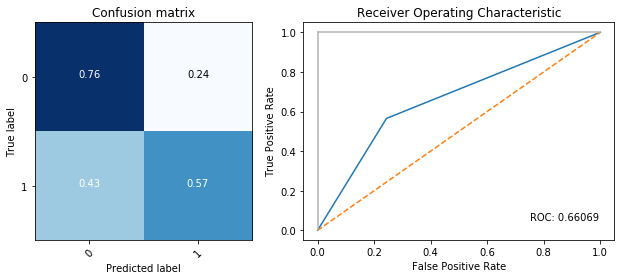

0.6606909762805345

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    ROS,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with ROS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     39594
     class 1       0.48      0.02      0.03      3636

    accuracy                           0.92     43230
   macro avg       0.70      0.51      0.49     43230
weighted avg       0.88      0.92      0.88     43230

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.06 0.06 0.07 0.08
 0.09 0.1  0.12 0.13 0.15 0.17 0.19 0.22 0.24 0.27 0.31 0.34 0.39 0.43
 0.48 0.54 0.6  0.66 0.72 0.79 0.85 0.91 0.96 0.99 1.  ] [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01
 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.04 0.05 0.05 0.06 0.07 0.08
 0.08 0.09 0.1  0.12 0.13 0.14 0.16 0.18 0.19 0.21 0.23 0.25 0.28 0.3
 0.32 0.34 0.37 0.4  0.44 0.47 0.5  0.54 0.57 0.6  0.64 0.67 0.71 0.76
 0.79 0.82 0.85 0.89 0.92 0.94 0.96 0.98 0.99 1.   

LR with ROS  RF with ROS
Accuracy                 0.740        0.916
Balanced accuracy        0.661        0.508
AUC                      0.727        0.724
Recall                   0.565        0.017
F-1 score                0.268        0.033
F-beta Score             0.391        0.021

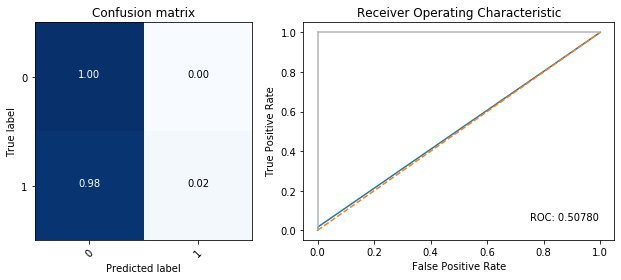

0.5078046503695679

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

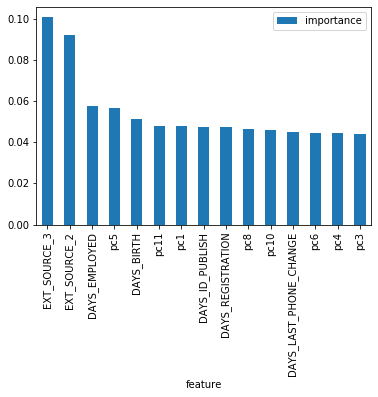

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ROS,SGDClassifier(penalty= 'l2', max_iter=1000, loss='hinge'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with ROS")
df_scores



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.80      0.86     39594
     class 1       0.18      0.50      0.27      3636

    accuracy                           0.77     43230
   macro avg       0.56      0.65      0.57     43230
weighted avg       0.88      0.77      0.81     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  SVM with ROS
Accuracy                 0.740        0.916         0.771
Balanced accuracy        0.661        0.508         0.649
AUC                      0.727        0.724         0.726
Recall                   0.565        0.017         0.502
F-1 score                0.268        0.033         0.269
F-beta Score             0.391        0.021         0.373

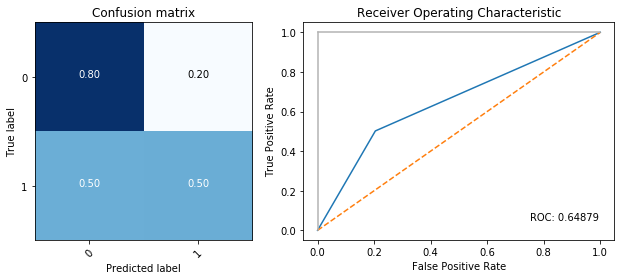

0.648788024354792

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   ROS,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with ROS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.77      0.85     39594
     class 1       0.19      0.59      0.29      3636

    accuracy                           0.75     43230
   macro avg       0.57      0.68      0.57     43230
weighted avg       0.89      0.75      0.80     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  SVM with ROS  XGB with ROS
Accuracy                 0.740        0.916         0.771         0.752
Balanced accuracy        0.661        0.508         0.649         0.677
AUC                      0.727        0.724         0.726         0.746
Recall                   0.565        0.017         0.502         0.587
F-1 score                0.268        0.033         0.269         0.285
F-beta Score             0.391        0.021         0.373         0.412

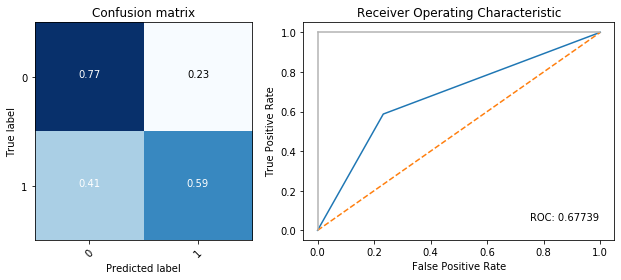

0.677387383760349

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

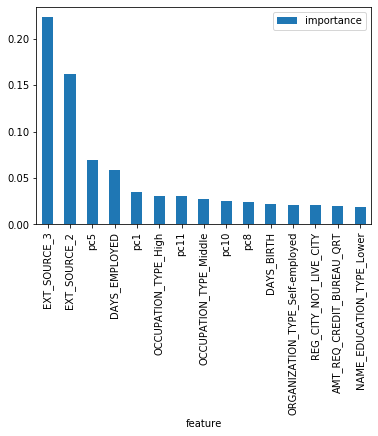

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
ROS,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with ROS")
df_scores



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      0.96      0.94     39594
     class 1       0.28      0.15      0.19      3636

    accuracy                           0.90     43230
   macro avg       0.60      0.56      0.57     43230
weighted avg       0.87      0.90      0.88     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  ...  XGB with ROS  LGBM with ROS
Accuracy                 0.740        0.916  ...         0.752          0.896
Balanced accuracy        0.661        0.508  ...         0.677          0.556
AUC                      0.727        0.724  ...         0.746          0.688
Recall                   0.565        0.017  ...         0.587          0.149
F-1 score                0.268        0.033  ...         0.285          0.193
F-beta Score             0.391        0.021  ...         0.412          0.164

[6 rows x 5 columns]

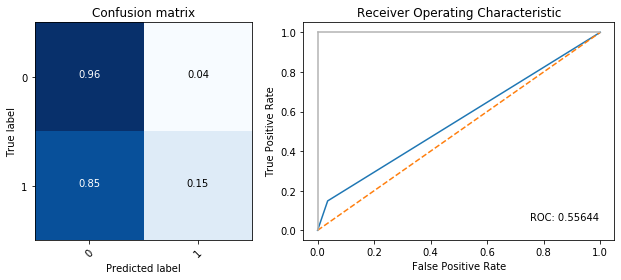

0.5564390694259607

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

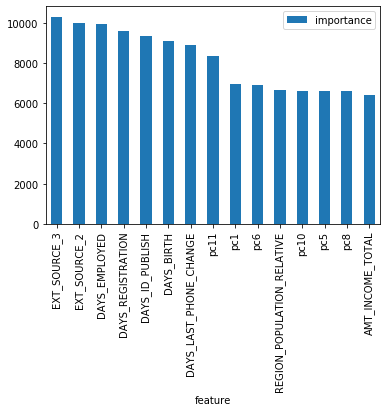

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 2-2. SMOTE

In [0]:
SMOTE = SMOTE(ratio='minority',random_state=0,sampling_strategy=0.8)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
   SMOTE ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with SMOTE")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    SMOTE,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with SMOTE")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    SMOTE,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with SMOTE")
df_scores


In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  SMOTE,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with SMOTE")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
SMOTE,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with SMOTE")
df_scores


In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

### 2-3. ADASYN

In [0]:
ADASYN= ADASYN(random_state=0,sampling_strategy=0.8).fit_sample(X_df, y_df)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
  ADASYN ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with ADASYN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
   ADASYN,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with ADASYN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ADASYN,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with ADASYN")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  ADASYN,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with ADASYN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
ADASYN,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with ADASYN")
df_scores


In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

## 3. 복합 Sampling

In [0]:
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import *

### 3-1. SMOTETomek

In [0]:
smt = SMOTETomek(ratio='auto',random_state=0,sampling_strategy=0.8)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
 smt ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with SMOTE + Tomek links")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGI

              precision    recall  f1-score   support

     class 0       0.96      0.68      0.79     39594
     class 1       0.16      0.66      0.25      3636

    accuracy                           0.67     43230
   macro avg       0.56      0.67      0.52     43230
weighted avg       0.89      0.67      0.75     43230

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with SMOTE + Tomek links
Accuracy                                 0.675
Balanced accuracy                        0.668
AUC                                      0.726
Recall                                   0.659
F-1 score                                0.254
F-beta Score                             0.186

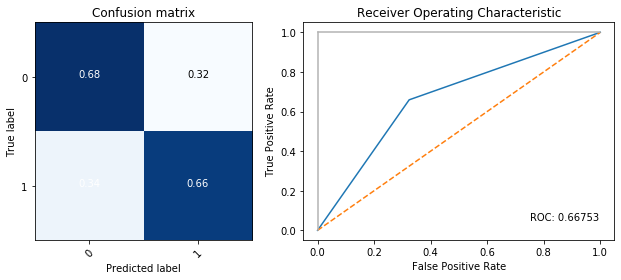

0.667526591271038

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    smt,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with SMOTE + Tomek links")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      0.98      0.95     39594
     class 1       0.26      0.06      0.10      3636

    accuracy                           0.91     43230
   macro avg       0.59      0.52      0.53     43230
weighted avg       0.86      0.91      0.88     43230

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03
 0.04 0.04 0.05 0.05 0.06 0.06 0.07 0.08 0.09 0.09 0.1  0.12 0.13 0.14
 0.15 0.17 0.18 0.2  0.22 0.24 0.26 0.28 0.31 0.34 0.37 0.4  0.43 0.46
 0.5  0.53 0.57 0.61 0.65 0.69 0.73 0.78 0.82 0.86 0.9  0.93 0.96 0.98
 0.99 1.   1.  ] [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.03
 0.03 0.03 0.04 0.04 0.05 0.05 0.06 0.06 0.07 0.08 0.09 0.1  0.11 0.12
 0.13 0.15 0.16 0.17 

LR with SMOTE + Tomek links  RF with SMOTE + Tomek links
Accuracy                                 0.675                        0.906
Balanced accuracy                        0.668                        0.524
AUC                                      0.726                        0.708
Recall                                   0.659                        0.064
F-1 score                                0.254                        0.103
F-beta Score                             0.186                        0.162

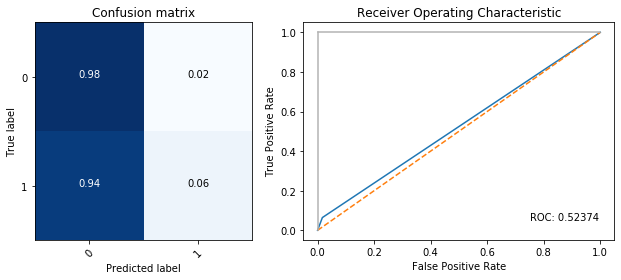

0.5237425962629602

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

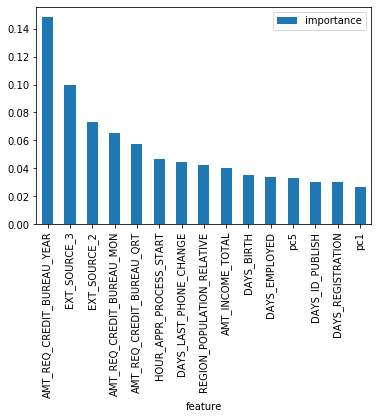

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
df_scores=pd.DataFrame()

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    smt,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with SMOTE + Tomek links")
df_scores



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.96      0.65      0.77     39594
     class 1       0.15      0.69      0.25      3636

    accuracy                           0.65     43230
   macro avg       0.56      0.67      0.51     43230
weighted avg       0.89      0.65      0.73     43230

[0.   0.   0.   ... 0.99 0.99 1.  ] [0. 0. 0. ... 1. 1. 1.]


SVM with SMOTE + Tomek links
Accuracy                                  0.654
Balanced accuracy                         0.671
AUC                                       0.725
Recall                                    0.692
F-1 score                                 0.252
F-beta Score                              0.407

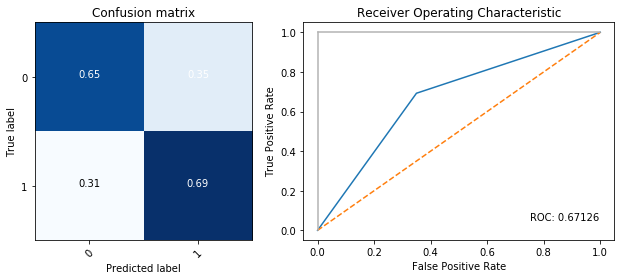

0.6712597593294714

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

AttributeError: ignored

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  smt,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with SMOTE + Tomek links")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
smt,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with SMOTE + Tomek links")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

### 3-2. SMOTEENN

In [0]:
sme = SMOTEENN(random_state=0,sampling_strategy=0.8).fit_sample(X_df, y_df)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
 sme ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with SMOTE + ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
   sme,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with SMOTE + ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
 sme,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with SMOTE + ENN")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  sme,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with SMOTE + ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
sme,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with SMOTE + ENN")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

# Model tuning - Our Best Model(XGBOOST with Random Under Sampling)

In [0]:

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns

In [199]:
X= df_simple.drop(['TARGET'], axis=1)
y= df_simple.TARGET
X, y = RandomUnderSampler(random_state=0, sampling_strategy=0.8).fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.steps[1][1].get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.steps[1][1].get_params()['n_estimators'], nfold=cv_folds,
            metrics='aucpr', early_stopping_rounds=early_stopping_rounds)
        alg.steps[1][1].set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors].values)
    dtrain_predprob = alg.predict_proba(dtrain[predictors].values)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("Balanced Accuracy : %.4g" % metrics.balanced_accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob))
    print ("Recall Score (Train): %f" % metrics.recall_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("F1 Score (Train): %f" % metrics.f1_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("Fbeta Score (Train): %f" % metrics.fbeta_score(dtrain['TARGET'].values, dtrain_predictions, 0.2))
          
    #feat_imp = alg.feature_importances_
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    return alg, alg.steps[1][1], dtrain['TARGET'].values, dtrain_predictions, dtrain_predprob

In [0]:
target = 'TARGET'
IDcol = 'SK_ID_CURR'

In [0]:
predictors = [x for x in df_simple.columns if x not in [target, IDcol]]

In [0]:
xgb1 = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42, sampling_strategy=0.8),XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
)

In [204]:
alg, alg2, y_test, y_pred, y_prob = modelfit(xgb1, df_simple, predictors)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Model Report
Accuracy : 0.7483
Balanced Accuracy : 0.698
AUC Score (Train): 0.777309
Recall Score (Train): 0.637796
F1 Score (Train): 0.296344
Fbeta Score (Train): 0.198332


In [205]:
xgb1.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=42, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.8)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=115, n_jobs=1, nthread=4,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=27, silent=None, subsample=0.8,
                            

In [0]:
def feature_importance_df_(feature_importances_):
  feature_importance_df = pd.DataFrame()
  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = predictors
  fold_importance_df["importance"] = feature_importances_
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
  return feature_importance_df
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Feature importance')
    plt.tight_layout()

In [0]:
feature_importance_df_ = feature_importance_df_(alg2.feature_importances_)

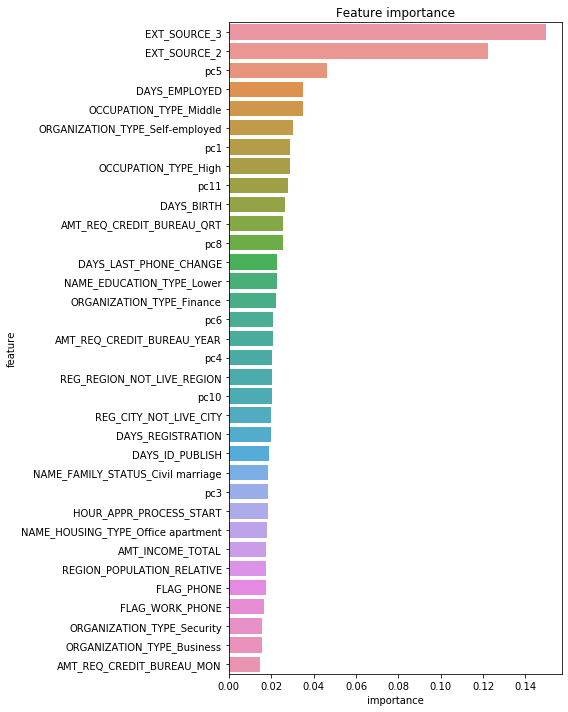

In [208]:
display_importances(feature_importance_df_ )

In [0]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
import itertools
##혼동행렬
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, cf_report=False,
                          title='Confusion matrix', ax=None, cmap=plt.cm.Blues, cbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    if cf_report:
        print(classification_report(y_true,y_pred))
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    
    if cbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # "Magic" numbers (https://stackoverflow.com/a/26720422/10939610)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

##ROC CURVE
def plot_roc(y_true, y_pred, ax=None):
    """Plot ROC curve""" 
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true,y_prob)
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)

    ax.set_title("Receiver Operating Characteristic")
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    ax.annotate('AUC: {:.5f}'.format(auc_score), [0.75,0.05])
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    fig.tight_layout()
    return auc_score

##혼동행렬 & ROC Curve
def plot_cmroc(y_true, y_pred, y_prob,classes=[0,1], normalize=True, cf_report=False):
    """Convenience function to plot confusion matrix and ROC curve """
    fig,axes = plt.subplots(1,2, figsize=(9,4))
    plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=normalize, cf_report=cf_report, ax=axes[0])
    auc_score = plot_roc(y_true, y_prob, ax=axes[1])
    fig.tight_layout()
    plt.show()
    return auc_score

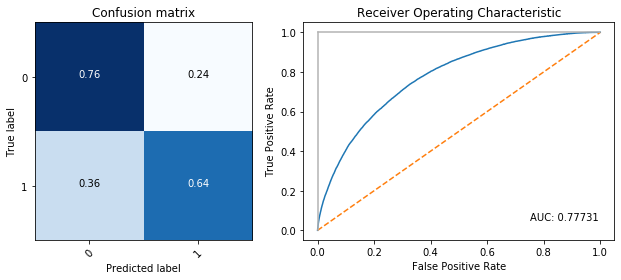

0.7773090987182378

In [210]:
plot_cmroc(y_test, y_pred, y_prob)